# Recurrent Neural Networks
## IE 7860 Winter 20202
## Kayleigh James

For this assignment I will be building a recurrent neural network for time series forcasting.  My dataset for this assignment is the Appliances energy prediction Data Set from the UCI data repository (https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction).

From the repository's description of the dataset:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

There are 29 attirbutes and 19735 observations.  Here are a list of the attributes:

date time year-month-day hour:minute:second

Appliances, energy use in Wh

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

I am choosing to use TensorFlow for this assignment and I used this tutorial for guidance:
https://www.tensorflow.org/tutorials/structured_data/time_series

First we will read the csv file in as a Pandas dataframe:

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tf.enable_eager_execution()

df_original = pd.read_csv('energydata_complete.csv')
df_original.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


First, I will train a model using only a single feature (Appliances), and use it to make predictions for that value in the future.

Let's first extract only the Appliance from the dataset.

In [2]:
df = df_original.Appliances
df.index = df_original.date
df.head()

date
2016-01-11 17:00:00    60
2016-01-11 17:10:00    60
2016-01-11 17:20:00    50
2016-01-11 17:30:00    50
2016-01-11 17:40:00    60
Name: Appliances, dtype: int64

Now, I will use a function from the linked tutorial above to return the window of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Set the random seed to ensure reproducability.  We will also set the size of the test/train split so we can use it as a constant.

In [4]:
tf.compat.v1.set_random_seed(13)
TRAIN_SPLIT = 10000

Now we will standardize the data.  We will subtract the mean and divide by the standard deviation.

In [5]:
data = df.values
train_mean = data[:TRAIN_SPLIT].mean()
train_std = data[:TRAIN_SPLIT].std()
data = (data-train_mean)/train_std

Now, create the data for the model. For this first part, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [6]:
past_history = 20
future_target = 0

x_train, y_train = univariate_data(data, 0, TRAIN_SPLIT, past_history, future_target)
x_val, y_val = univariate_data(data, TRAIN_SPLIT, None, past_history, future_target)

print ('Single window of past history')
print (x_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
[[-0.3564048 ]
 [-0.3564048 ]
 [-0.44838023]
 [-0.44838023]
 [-0.3564048 ]
 [-0.44838023]
 [-0.3564048 ]
 [-0.3564048 ]
 [-0.3564048 ]
 [-0.26442937]
 [ 1.20717754]
 [ 4.42631765]
 [ 3.04668618]
 [ 1.3911284 ]
 [ 0.01149693]
 [ 0.01149693]
 [-0.0804785 ]
 [-0.26442937]
 [-0.17245393]
 [ 0.37939866]]

 Target temperature to predict
0.19544779243051325


Now let's visualize what data we have and the data we are trying to predict.  The blue line in the plot covers the 20 points we will put into the model and the red X is the point we are trying to predict.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

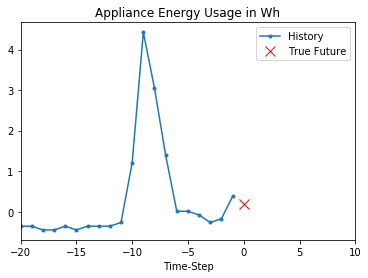

In [7]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train[0], y_train[0]], 0, 'Appliance Energy Usage in Wh')

Let's set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.  This is what the graph would look like if we did so:

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

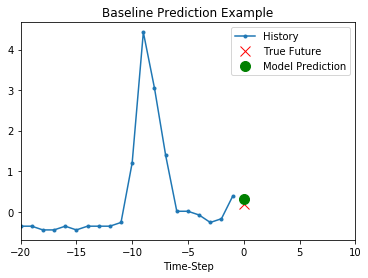

In [8]:
show_plot([x_train[0], y_train[0], np.mean(x_train[0])], 0,
           'Baseline Prediction Example')

As we can see the baseline model actually would do a fairly good job of predicting the value at our selected time.  Let's see if we can improve on it with an RNN model.  In my RNN model I will be using a LSTM layer. 

In [9]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/10
Instructions for updating:
Use tf.cast instead.
200/200 [==============================] - 7s 36ms/step - loss: 0.4109 - val_loss: 0.2977
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.3410 - val_loss: 0.2520
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2909 - val_loss: 0.2324
Epoch 4/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2814 - val_loss: 0.2313
Epoch 5/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2752 - val_loss: 0.2307
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2765 - val_loss: 0.2301
Epoch 7/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2737 - val_loss: 0.2300
Epoch 8/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2743 - val_loss: 0.2285
Epoch 9/10
200/200 [==============================] - 6s 28ms/step - los

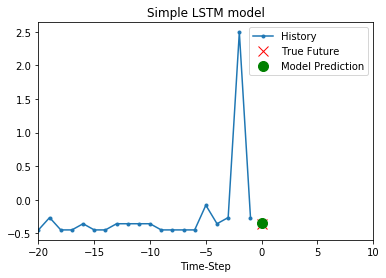

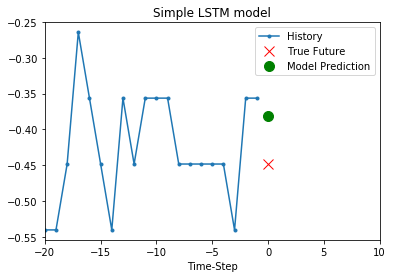

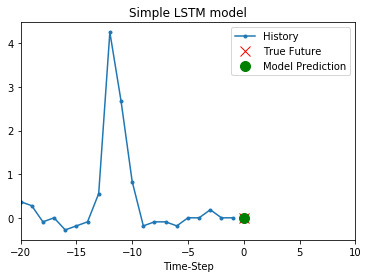

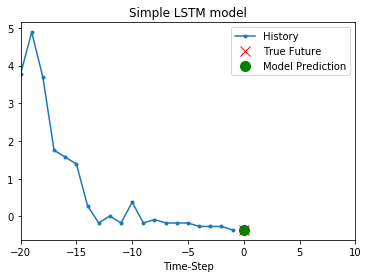

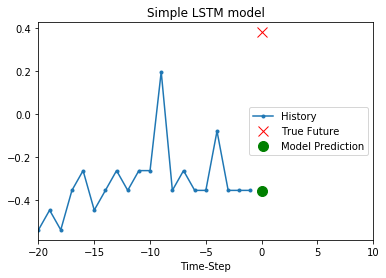

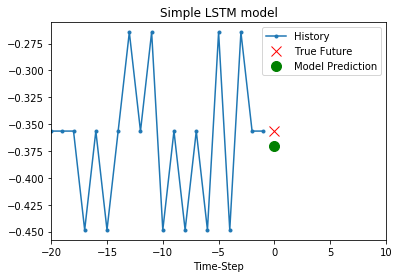

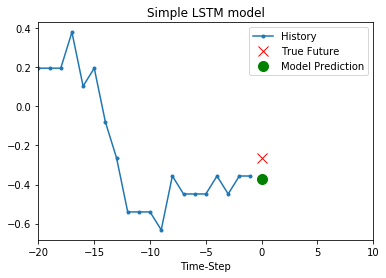

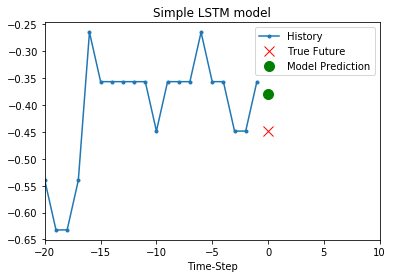

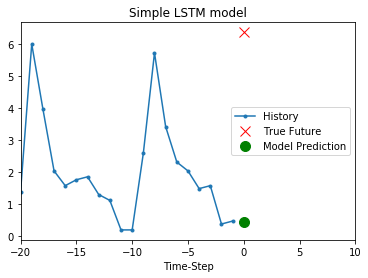

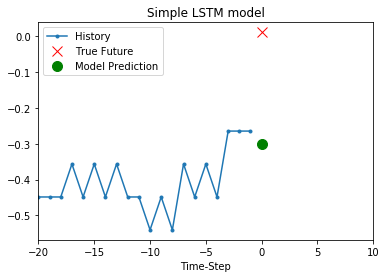

In [10]:
for x, y in val_univariate.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x.numpy())[0]], 0, 'Simple LSTM model')
  plot.show()

We can see that the univariate model sometimes does extremely well when predicting the future, but in other circumstances it does a very poor job.  We will now try a multivariate model that incorportates some of the other features. 

In [11]:
features_considered = ['Appliances', 'lights', 'T_out', 'T1']
features = df_original[features_considered]
features.index = df_original.date
features.head()

,Appliances,lights,T_out,T1
date,,,,
2016-01-11 17:00:00,60,30,6.600000,19.89
2016-01-11 17:10:00,60,30,6.483333,19.89
2016-01-11 17:20:00,50,30,6.366667,19.89
2016-01-11 17:30:00,50,40,6.250000,19.89
2016-01-11 17:40:00,60,40,6.133333,19.89


array([<matplotlib.axes._subplots.AxesSubplot object at 0xb35829cf8>,
      dtype=object)

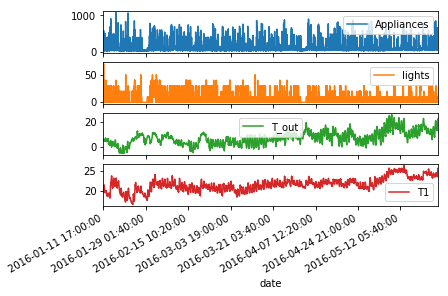

In [12]:
features.plot(subplots=True)

As we did in the univariate model, we will now standardize the data.

In [13]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

First we will build a single step model where the model learns to predict a single point in the future based on some history provided.  

In [14]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five days, i.e. 720 observations (we have samples taken every 10 minutes)

In [15]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 4)


In [16]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 38s 188ms/step - loss: 0.5807 - val_loss: 0.3002
Epoch 2/10
200/200 [==============================] - 35s 177ms/step - loss: 0.5609 - val_loss: 0.3166
Epoch 3/10
200/200 [==============================] - 35s 177ms/step - loss: 0.5519 - val_loss: 0.4673
Epoch 4/10
200/200 [==============================] - 35s 176ms/step - loss: 0.5394 - val_loss: 0.7438
Epoch 5/10
200/200 [==============================] - 35s 176ms/step - loss: 0.5132 - val_loss: 0.7070
Epoch 6/10
200/200 [==============================] - 35s 176ms/step - loss: 0.4976 - val_loss: 0.7238
Epoch 7/10
200/200 [==============================] - 35s 176ms/step - loss: 0.4878 - val_loss: 0.7737
Epoch 8/10
200/200 [==============================] - 35s 175ms/step - loss: 0.4790 - val_loss: 0.7982
Epoch 9/10
200/200 [==============================] - 35s 176ms/step - loss: 0.4769 - val_loss: 0.8393
Epoch 10/10
200/200 [==============================] - 35s 174ms/step - l

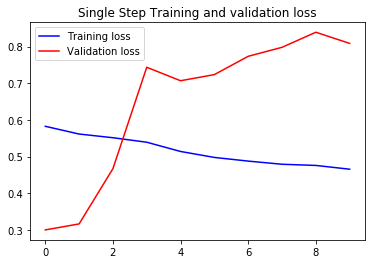

In [17]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,'Single Step Training and validation loss')

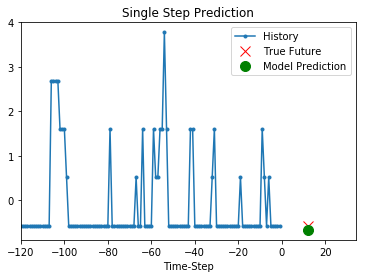

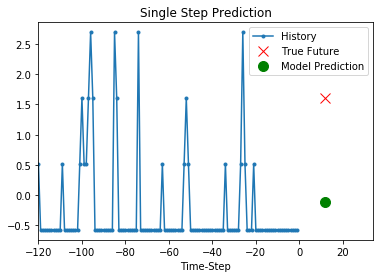

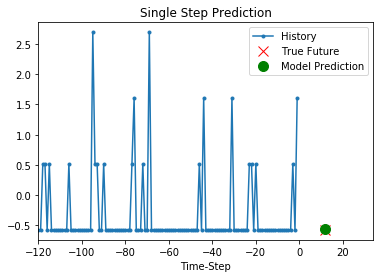

In [18]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x.numpy())[0]], 12,
                   'Single Step Prediction')
  plot.show()

Since our model did not do well predicting, and we had increasing validation loss, I think the model is overfitting.  To try to rectify this I will add combined L2 regularization and a dropout layer.

In [19]:
from tensorflow.keras import regularizers

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, kernel_regularizer=regularizers.l2(0.0001),
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.5))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/10
200/200 [==============================] - 35s 177ms/step - loss: 0.6264 - val_loss: 0.5492
Epoch 2/10
200/200 [==============================] - 32s 162ms/step - loss: 0.5727 - val_loss: 0.6042
Epoch 3/10
200/200 [==============================] - 32s 162ms/step - loss: 0.5459 - val_loss: 0.7613
Epoch 4/10
200/200 [==============================] - 32s 160ms/step - loss: 0.5326 - val_loss: 0.7580
Epoch 5/10
200/200 [==============================] - 32s 161ms/step - loss: 0.5258 - val_loss: 0.7124
Epoch 6/10
200/200 [==============================] - 33s 163ms/step - loss: 0.5274 - val_loss: 0.4957
Epoch 7/10
200/200 [==============================] - 48s 239ms/step - loss: 0.5141 - val_loss: 0.5529
Epoch 8/10
200/200 [==============================] - 424s 2s/step - loss: 0.5110 - val_loss: 0.5268
Epoch 9/10
200/200 [==============================] - 39s 194ms

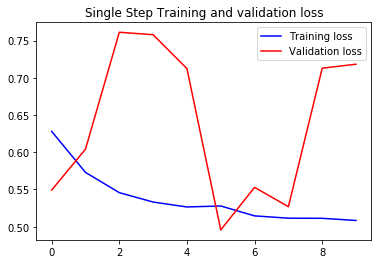

In [20]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

Adding the regularization and dropout layer definitely help the validation loss.  Now we can see that the model doesn't experience nearly as much overfitting.  

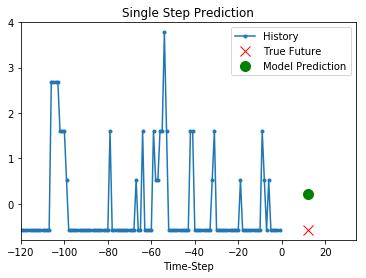

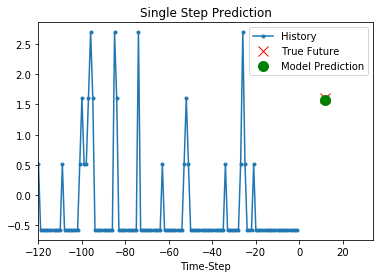

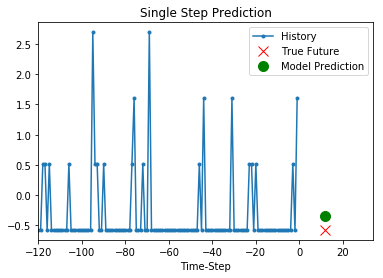

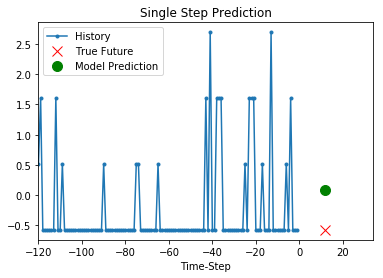

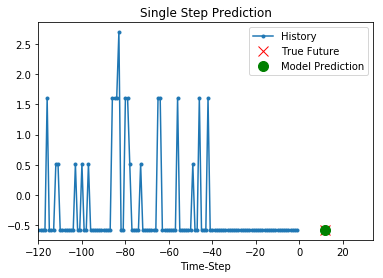

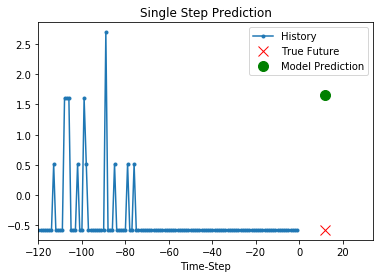

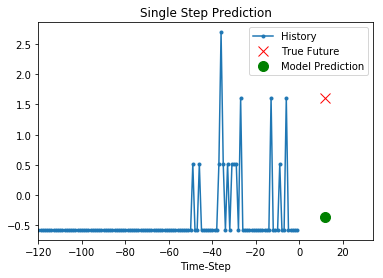

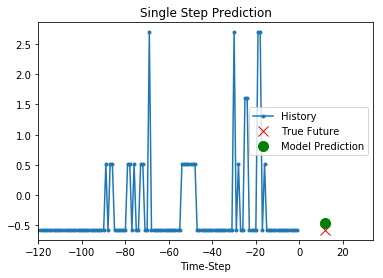

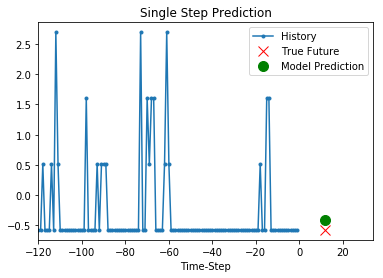

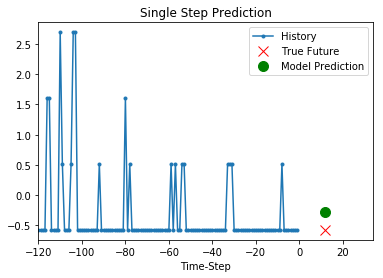

In [21]:
for x, y in val_data_single.take(10):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x.numpy())[0]], 12,
                   'Single Step Prediction')
  plot.show()

This looks like a much better model for predicting a single step than the model without regularization and dropout and better than the simple univariate model.  Now let's move onto a multistep model.  In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [22]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, kernel_regularizer=regularizers.l2(0.0001),
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.LSTM(16, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
single_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 68s 339ms/step - loss: 0.6350 - val_loss: 0.2916
Epoch 2/10
200/200 [==============================] - 60s 298ms/step - loss: 0.5740 - val_loss: 0.2950
Epoch 3/10
200/200 [==============================] - 60s 299ms/step - loss: 0.5654 - val_loss: 0.3561
Epoch 4/10
200/200 [==============================] - 60s 302ms/step - loss: 0.5621 - val_loss: 0.3887
Epoch 5/10
200/200 [==============================] - 62s 312ms/step - loss: 0.5593 - val_loss: 0.3866
Epoch 6/10
200/200 [==============================] - 60s 301ms/step - loss: 0.5589 - val_loss: 0.3789
Epoch 7/10
200/200 [==============================] - 61s 303ms/step - loss: 0.5562 - val_loss: 0.3667
Epoch 8/10
200/200 [==============================] - 61s 303ms/step - loss: 0.5536 - val_loss: 0.3951
Epoch 9/10
200/200 [==============================] - 60s 301ms/step - loss: 0.5522 - val_loss: 0.4047
Epoch 10/10
200/200 [==============================] - 61s 303ms/step - l

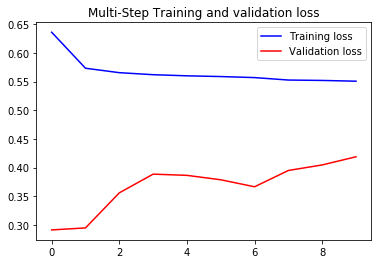

In [23]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

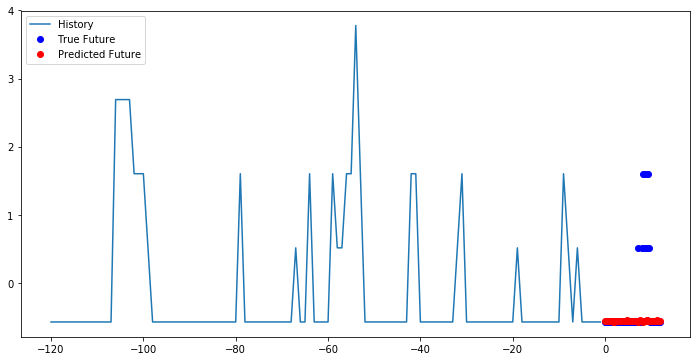

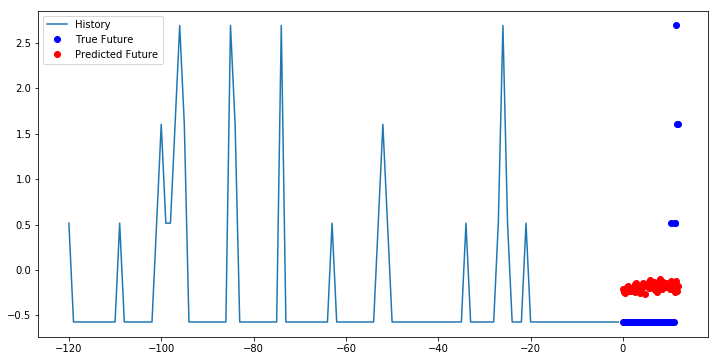

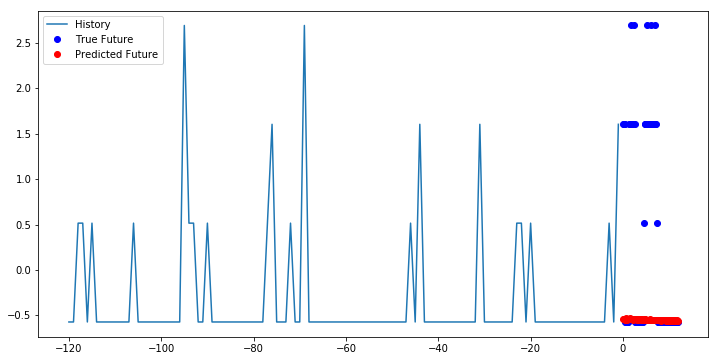

In [36]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x.numpy())[0])

Overall this RNN did not perform well on the dataset.  I think this is due to the nature of the dataset.  Since this is power usage for appliances, the data spikes and then remains 0 most of the time as we turn appliances on and off. For some appliances (e.g. a coffee maker or a toaster which may be routinely used in the morning at a regular time) that are routine oriented we may be able to predict energy usage, but other appliances are used more sporadically like the stove.  Some days the stove may be used for lunch and sometimes for dinner.  Instead of predicting appliance energy usage, I will re-try to model we built with the light usage dataset.  Seeing as the sunset/sunrise is more regular lights usage may be easier to predict.  I will just skip to this final step using the model we have built and see if it works better using light energy usage instead of appliance energy usage.

In [38]:
features_considered = ['lights', 'T_out', 'T1']
features = df_original[features_considered]
features.index = df_original.date
features.head()
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

past_history = 720
future_target = 72
STEP = 6

future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, kernel_regularizer=regularizers.l2(0.0001),
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.LSTM(16, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
single_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)



Epoch 1/10
200/200 [==============================] - 65s 324ms/step - loss: 1248362.6395 - val_loss: 98.7708
Epoch 2/10
200/200 [==============================] - 60s 299ms/step - loss: 282.4747 - val_loss: 9.3584
Epoch 3/10
200/200 [==============================] - 60s 302ms/step - loss: 158518955372.1753 - val_loss: 1.2464
Epoch 4/10
200/200 [==============================] - 60s 302ms/step - loss: 1236.1775 - val_loss: 1.0989
Epoch 5/10
200/200 [==============================] - 60s 301ms/step - loss: 1022652488350.0398 - val_loss: 1.1810
Epoch 6/10
200/200 [==============================] - 60s 301ms/step - loss: 0.5077 - val_loss: 1.1042
Epoch 7/10
200/200 [==============================] - 60s 301ms/step - loss: 0.3761 - val_loss: 1.0111
Epoch 8/10
200/200 [==============================] - 60s 300ms/step - loss: 0.2870 - val_loss: 1.2264
Epoch 9/10
200/200 [==============================] - 60s 301ms/step - loss: 0.2369 - val_loss: 1.0853
Epoch 10/10
200/200 [=================

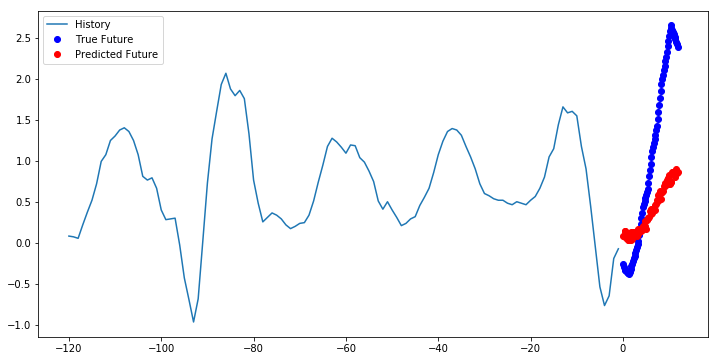

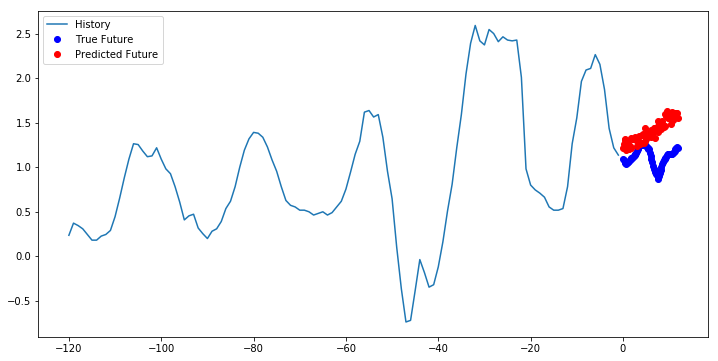

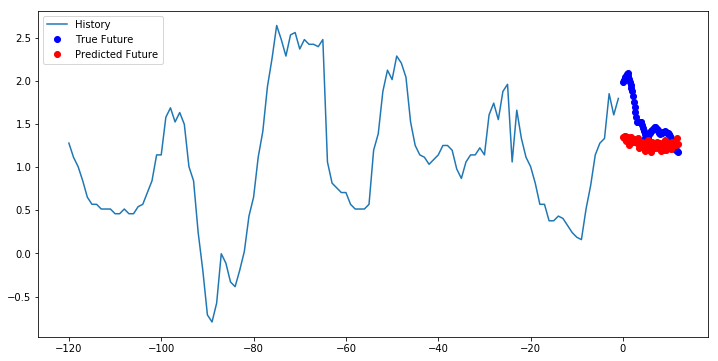

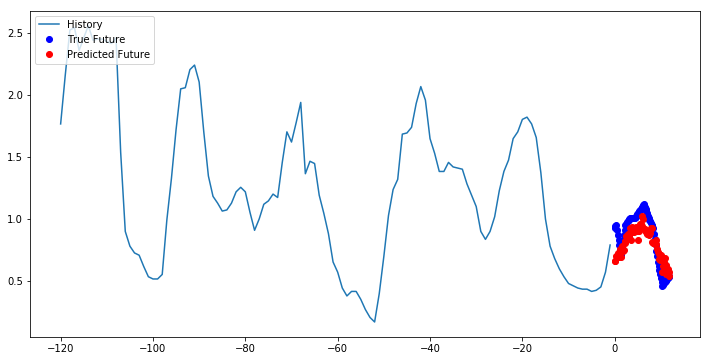

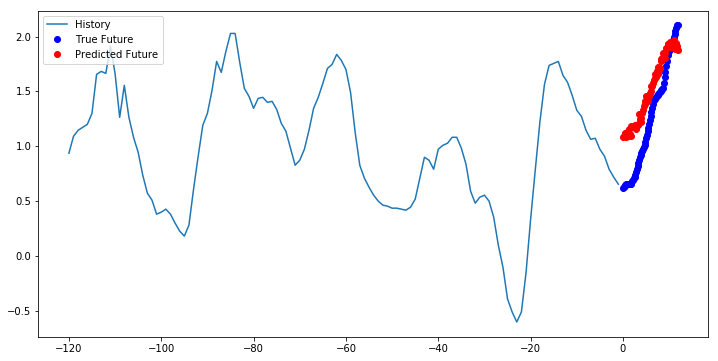

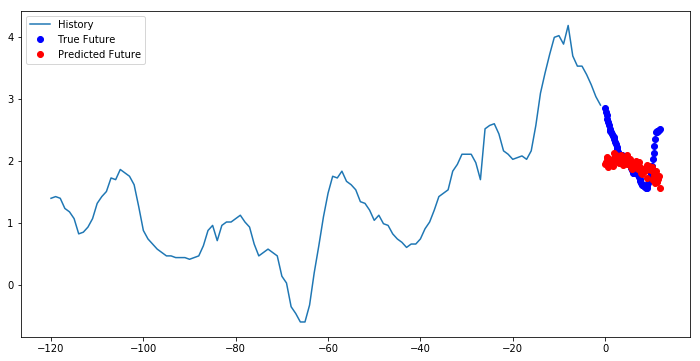

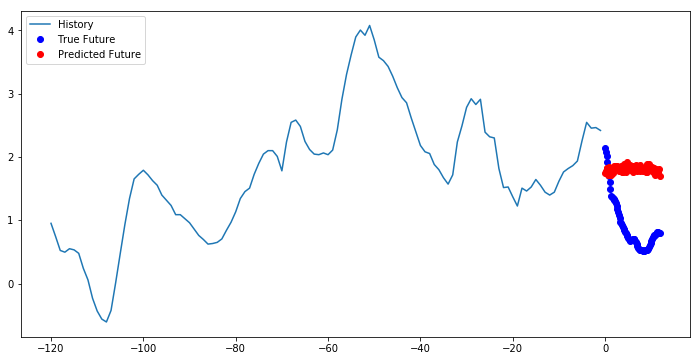

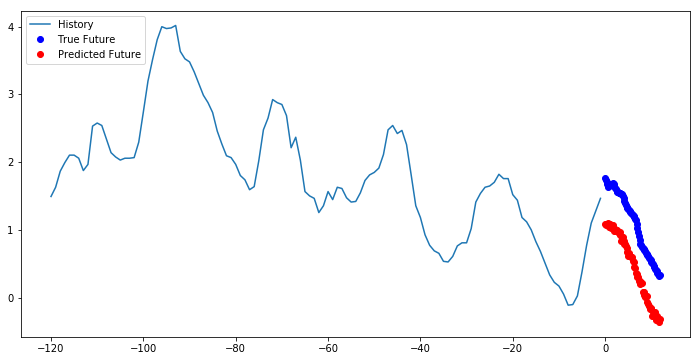

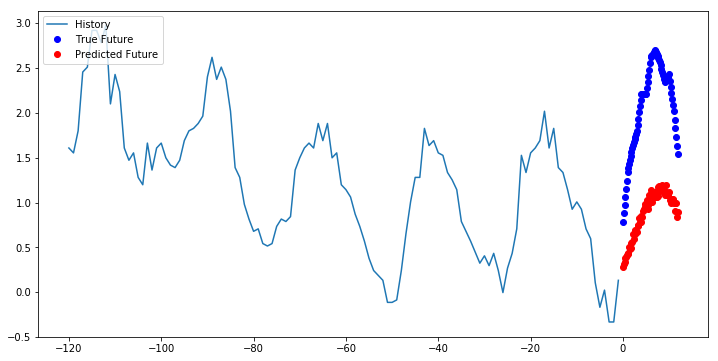

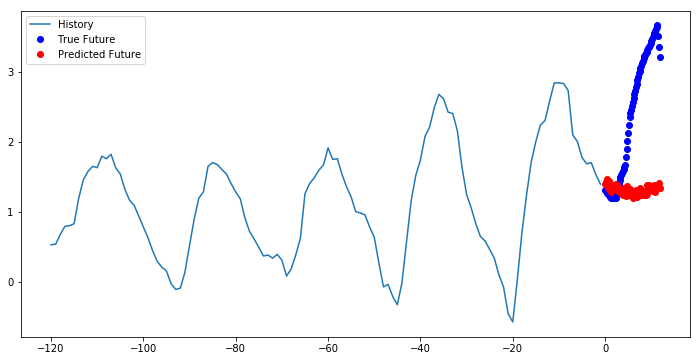

In [40]:
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x.numpy())[0])

As we can see there is a noticeable pattern for the light energy usage and for some cases it was very accurate.  To further improve this model we could try to add more features to the input vector.  Overall this was a very challenging dataset to work with as there wasn't a pattern for the original target variable I selected.  It was very erratic and the values were either 0 or maxed out, there weren't many smooth curves to train on which made it difficult for the neural network to predict.  